# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11845
EM converged at iteration 34, llf=-11612, convergence criterion=9.2464e-07 < tolerance=1e-06
EM start iterations, llf=-11858
EM converged at iteration 34, llf=-11625, convergence criterion=9.2441e-07 < tolerance=1e-06
EM start iterations, llf=-11913
EM converged at iteration 34, llf=-11677, convergence criterion=9.3574e-07 < tolerance=1e-06
EM start iterations, llf=-11920
EM converged at iteration 34, llf=-11685, convergence criterion=9.373e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM converged at iteration 33, llf=-11745, convergence criterion=9.9138e-07 < tolerance=1e-06
EM start iterations, llf=-11994
EM converged at iteration 33, llf=-11752, convergence criterion=9.7969e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM converged at iteration 34, llf=-11808, convergence criterion=9.3411e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM converged at iteration 34, llf=-11808, convergence criterion=9.3411e-07 < tolerance=1e-06
E

EM start iterations, llf=-13571
EM converged at iteration 27, llf=-13386, convergence criterion=9.4611e-07 < tolerance=1e-06
EM start iterations, llf=-13636
EM converged at iteration 25, llf=-13459, convergence criterion=9.2455e-07 < tolerance=1e-06
EM start iterations, llf=-13642
EM converged at iteration 28, llf=-13463, convergence criterion=9.1321e-07 < tolerance=1e-06
EM start iterations, llf=-13693
EM converged at iteration 29, llf=-13509, convergence criterion=9.4249e-07 < tolerance=1e-06
EM start iterations, llf=-13693
EM converged at iteration 29, llf=-13509, convergence criterion=9.4249e-07 < tolerance=1e-06
EM start iterations, llf=-13704
EM converged at iteration 30, llf=-13522, convergence criterion=9.5832e-07 < tolerance=1e-06
EM start iterations, llf=-13756
EM converged at iteration 30, llf=-13574, convergence criterion=9.0625e-07 < tolerance=1e-06
EM start iterations, llf=-13761
EM converged at iteration 31, llf=-13579, convergence criterion=8.9006e-07 < tolerance=1e-06


EM start iterations, llf=-15313
EM converged at iteration 31, llf=-15115, convergence criterion=9.6915e-07 < tolerance=1e-06
EM start iterations, llf=-15313
EM converged at iteration 31, llf=-15115, convergence criterion=9.6915e-07 < tolerance=1e-06
EM start iterations, llf=-15323
EM converged at iteration 31, llf=-15124, convergence criterion=9.6893e-07 < tolerance=1e-06
EM start iterations, llf=-15376
EM converged at iteration 31, llf=-15178, convergence criterion=9.4336e-07 < tolerance=1e-06
EM start iterations, llf=-15387
EM converged at iteration 31, llf=-15189, convergence criterion=9.3288e-07 < tolerance=1e-06
EM start iterations, llf=-15437
EM converged at iteration 31, llf=-15239, convergence criterion=9.0931e-07 < tolerance=1e-06
EM start iterations, llf=-15445
EM converged at iteration 31, llf=-15246, convergence criterion=8.8604e-07 < tolerance=1e-06
EM start iterations, llf=-15493
EM converged at iteration 31, llf=-15292, convergence criterion=8.7552e-07 < tolerance=1e-06


EM start iterations, llf=-17017
EM converged at iteration 29, llf=-16788, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-17021
EM converged at iteration 29, llf=-16793, convergence criterion=9.7203e-07 < tolerance=1e-06
EM start iterations, llf=-17074
EM converged at iteration 29, llf=-16845, convergence criterion=9.4428e-07 < tolerance=1e-06
EM start iterations, llf=-17081
EM converged at iteration 29, llf=-16852, convergence criterion=9.5327e-07 < tolerance=1e-06
EM start iterations, llf=-17138
EM converged at iteration 29, llf=-16909, convergence criterion=9.472e-07 < tolerance=1e-06
EM start iterations, llf=-17138
EM converged at iteration 29, llf=-16909, convergence criterion=9.472e-07 < tolerance=1e-06
EM start iterations, llf=-17147
EM converged at iteration 29, llf=-16919, convergence criterion=9.3045e-07 < tolerance=1e-06
EM start iterations, llf=-17199
EM converged at iteration 29, llf=-16971, convergence criterion=8.8497e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18541
EM converged at iteration 25, llf=-18302, convergence criterion=9.5844e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 25, llf=-18359, convergence criterion=9.4955e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 25, llf=-18359, convergence criterion=9.4955e-07 < tolerance=1e-06
EM start iterations, llf=-18605
EM converged at iteration 25, llf=-18364, convergence criterion=9.5009e-07 < tolerance=1e-06
EM start iterations, llf=-18658
EM converged at iteration 25, llf=-18416, convergence criterion=9.8672e-07 < tolerance=1e-06
EM start iterations, llf=-18665
EM converged at iteration 25, llf=-18423, convergence criterion=9.8773e-07 < tolerance=1e-06
EM start iterations, llf=-18721
EM converged at iteration 25, llf=-18478, convergence criterion=9.7847e-07 < tolerance=1e-06
EM start iterations, llf=-18728
EM converged at iteration 25, llf=-18486, convergence criterion=9.8478e-07 < tolerance=1e-06


EM start iterations, llf=-12411
EM converged at iteration 54, llf=-12151, convergence criterion=9.6776e-07 < tolerance=1e-06
EM start iterations, llf=-12394
EM converged at iteration 53, llf=-12130, convergence criterion=9.8164e-07 < tolerance=1e-06
EM start iterations, llf=-12453
EM converged at iteration 51, llf=-12199, convergence criterion=9.6166e-07 < tolerance=1e-06
EM start iterations, llf=-12472
EM converged at iteration 51, llf=-12224, convergence criterion=9.6824e-07 < tolerance=1e-06
EM start iterations, llf=-12510
EM converged at iteration 54, llf=-12285, convergence criterion=9.9432e-07 < tolerance=1e-06
EM start iterations, llf=-12509
EM converged at iteration 54, llf=-12282, convergence criterion=9.7876e-07 < tolerance=1e-06
EM start iterations, llf=-12524
EM converged at iteration 51, llf=-12306, convergence criterion=9.8671e-07 < tolerance=1e-06
EM start iterations, llf=-12524
EM converged at iteration 51, llf=-12306, convergence criterion=9.8671e-07 < tolerance=1e-06


EM start iterations, llf=-14119
EM converged at iteration 51, llf=-13925, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-14159
EM converged at iteration 50, llf=-13957, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-14164
EM converged at iteration 52, llf=-13969, convergence criterion=9.7001e-07 < tolerance=1e-06
EM start iterations, llf=-14237
EM converged at iteration 57, llf=-14048, convergence criterion=9.7081e-07 < tolerance=1e-06
EM start iterations, llf=-14237
EM converged at iteration 57, llf=-14048, convergence criterion=9.7081e-07 < tolerance=1e-06
EM start iterations, llf=-14247
EM converged at iteration 57, llf=-14059, convergence criterion=9.7298e-07 < tolerance=1e-06
EM start iterations, llf=-14287
EM converged at iteration 57, llf=-14097, convergence criterion=9.7946e-07 < tolerance=1e-06
EM start iterations, llf=-14294
EM converged at iteration 56, llf=-14104, convergence criterion=9.8298e-07 < tolerance=1e-06


EM start iterations, llf=-15863
EM converged at iteration 43, llf=-15651, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-15863
EM converged at iteration 43, llf=-15651, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-15871
EM converged at iteration 43, llf=-15659, convergence criterion=9.7592e-07 < tolerance=1e-06
EM start iterations, llf=-15925
EM converged at iteration 43, llf=-15711, convergence criterion=9.7627e-07 < tolerance=1e-06
EM start iterations, llf=-15928
EM converged at iteration 43, llf=-15713, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-15981
EM converged at iteration 44, llf=-15766, convergence criterion=9.8645e-07 < tolerance=1e-06
EM start iterations, llf=-15986
EM converged at iteration 44, llf=-15770, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-16030
EM converged at iteration 44, llf=-15815, convergence criterion=9.7647e-07 < tolerance=1e-06


EM start iterations, llf=-17574
EM converged at iteration 37, llf=-17349, convergence criterion=9.5619e-07 < tolerance=1e-06
EM start iterations, llf=-17579
EM converged at iteration 37, llf=-17354, convergence criterion=9.5577e-07 < tolerance=1e-06
EM start iterations, llf=-17635
EM converged at iteration 36, llf=-17409, convergence criterion=9.8665e-07 < tolerance=1e-06
EM start iterations, llf=-17643
EM converged at iteration 36, llf=-17416, convergence criterion=9.8588e-07 < tolerance=1e-06
EM start iterations, llf=-17692
EM converged at iteration 36, llf=-17464, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-17692
EM converged at iteration 36, llf=-17464, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-17711
EM converged at iteration 36, llf=-17484, convergence criterion=9.8343e-07 < tolerance=1e-06
EM start iterations, llf=-17764
EM converged at iteration 35, llf=-17537, convergence criterion=9.8575e-07 < tolerance=1e-06


EM start iterations, llf=-19088
EM converged at iteration 37, llf=-18835, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-19137
EM converged at iteration 36, llf=-18885, convergence criterion=9.9515e-07 < tolerance=1e-06
EM start iterations, llf=-19137
EM converged at iteration 36, llf=-18885, convergence criterion=9.9515e-07 < tolerance=1e-06
EM start iterations, llf=-19145
EM converged at iteration 36, llf=-18895, convergence criterion=9.9318e-07 < tolerance=1e-06
EM start iterations, llf=-19203
EM converged at iteration 36, llf=-18952, convergence criterion=9.9835e-07 < tolerance=1e-06
EM start iterations, llf=-19211
EM converged at iteration 36, llf=-18960, convergence criterion=9.97e-07 < tolerance=1e-06
EM start iterations, llf=-19264
EM converged at iteration 36, llf=-19012, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-19273
EM converged at iteration 36, llf=-19020, convergence criterion=9.9833e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12886
EM converged at iteration 50, llf=-12680, convergence criterion=9.6434e-07 < tolerance=1e-06
EM start iterations, llf=-12892
EM converged at iteration 50, llf=-12687, convergence criterion=9.6123e-07 < tolerance=1e-06
EM start iterations, llf=-12945
EM converged at iteration 49, llf=-12737, convergence criterion=9.6154e-07 < tolerance=1e-06
EM start iterations, llf=-12952
EM converged at iteration 49, llf=-12744, convergence criterion=9.6467e-07 < tolerance=1e-06
EM start iterations, llf=-12996
EM converged at iteration 47, llf=-12782, convergence criterion=9.6891e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM converged at iteration 47, llf=-12792, convergence criterion=9.5947e-07 < tolerance=1e-06
EM start iterations, llf=-13067
EM converged at iteration 49, llf=-12860, convergence criterion=9.5824e-07 < tolerance=1e-06
EM start iterations, llf=-13067
EM converged at iteration 49, llf=-12860, convergence criterion=9.5824e-07 < tolerance=1e-06


EM start iterations, llf=-14646
EM converged at iteration 51, llf=-14452, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-14701
EM converged at iteration 50, llf=-14511, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-14710
EM converged at iteration 50, llf=-14516, convergence criterion=9.6455e-07 < tolerance=1e-06
EM start iterations, llf=-14765
EM converged at iteration 51, llf=-14573, convergence criterion=9.6126e-07 < tolerance=1e-06
EM start iterations, llf=-14765
EM converged at iteration 51, llf=-14573, convergence criterion=9.6126e-07 < tolerance=1e-06
EM start iterations, llf=-14773
EM converged at iteration 50, llf=-14580, convergence criterion=9.7795e-07 < tolerance=1e-06
EM start iterations, llf=-14828
EM converged at iteration 50, llf=-14634, convergence criterion=9.5499e-07 < tolerance=1e-06
EM start iterations, llf=-14837
EM converged at iteration 49, llf=-14641, convergence criterion=9.541e-07 < tolerance=1e-06
E

EM start iterations, llf=-16403
EM converged at iteration 45, llf=-16188, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-16403
EM converged at iteration 45, llf=-16188, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-16412
EM converged at iteration 45, llf=-16197, convergence criterion=9.6897e-07 < tolerance=1e-06
EM start iterations, llf=-16466
EM converged at iteration 45, llf=-16249, convergence criterion=9.5845e-07 < tolerance=1e-06
EM start iterations, llf=-16475
EM converged at iteration 45, llf=-16259, convergence criterion=9.5555e-07 < tolerance=1e-06
EM start iterations, llf=-16524
EM converged at iteration 44, llf=-16308, convergence criterion=9.9023e-07 < tolerance=1e-06
EM start iterations, llf=-16532
EM converged at iteration 44, llf=-16315, convergence criterion=9.8728e-07 < tolerance=1e-06
EM start iterations, llf=-16584
EM converged at iteration 44, llf=-16365, convergence criterion=9.8186e-07 < tolerance=1e-06


EM start iterations, llf=-18111
EM converged at iteration 39, llf=-17879, convergence criterion=9.751e-07 < tolerance=1e-06
EM start iterations, llf=-18118
EM converged at iteration 39, llf=-17887, convergence criterion=9.6996e-07 < tolerance=1e-06
EM start iterations, llf=-18168
EM converged at iteration 39, llf=-17937, convergence criterion=9.7003e-07 < tolerance=1e-06
EM start iterations, llf=-18176
EM converged at iteration 39, llf=-17944, convergence criterion=9.7097e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 39, llf=-17997, convergence criterion=9.7435e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 39, llf=-17997, convergence criterion=9.7435e-07 < tolerance=1e-06
EM start iterations, llf=-18233
EM converged at iteration 39, llf=-17999, convergence criterion=9.7575e-07 < tolerance=1e-06
EM start iterations, llf=-18285
EM converged at iteration 39, llf=-18050, convergence criterion=9.7317e-07 < tolerance=1e-06
E

EM start iterations, llf=-19348
EM converged at iteration 39, llf=-19091, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-19403
EM converged at iteration 39, llf=-19146, convergence criterion=9.8402e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:34:59.351160.
EM start iterations, llf=-11365
EM converged at iteration 27, llf=-11228, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-11378
EM converged at iteration 27, llf=-11241, convergence criterion=9.9163e-07 < tolerance=1e-06
EM start iterations, llf=-11432
EM converged at iteration 27, llf=-11295, convergence criterion=9.7106e-07 < tolerance=1e-06
EM start iterations, llf=-11440
EM converged at iteration 27, llf=-11303, convergence criterion=9.7581e-07 < tolerance=1e-06
EM start iterations, llf=-11498
EM converged at iteration 25, llf=-11362, convergence criterion=9.5341e-07 < tolerance=1e-06
EM start iterations, llf=-11509
EM converged at

EM start iterations, llf=-12854
EM converged at iteration 25, llf=-12709, convergence criterion=9.8725e-07 < tolerance=1e-06
EM start iterations, llf=-12867
EM converged at iteration 25, llf=-12721, convergence criterion=9.9583e-07 < tolerance=1e-06
EM start iterations, llf=-12899
EM converged at iteration 26, llf=-12753, convergence criterion=9.3883e-07 < tolerance=1e-06
EM start iterations, llf=-12905
EM converged at iteration 26, llf=-12756, convergence criterion=9.5828e-07 < tolerance=1e-06
EM start iterations, llf=-12967
EM converged at iteration 26, llf=-12812, convergence criterion=9.665e-07 < tolerance=1e-06
EM start iterations, llf=-12972
EM converged at iteration 26, llf=-12820, convergence criterion=9.4562e-07 < tolerance=1e-06
EM start iterations, llf=-13012
EM converged at iteration 25, llf=-12859, convergence criterion=9.7622e-07 < tolerance=1e-06
EM start iterations, llf=-13012
EM converged at iteration 25, llf=-12859, convergence criterion=9.7622e-07 < tolerance=1e-06
E

EM start iterations, llf=-14469
EM converged at iteration 23, llf=-14308, convergence criterion=9.5878e-07 < tolerance=1e-06
EM start iterations, llf=-14521
EM converged at iteration 21, llf=-14361, convergence criterion=9.8906e-07 < tolerance=1e-06
EM start iterations, llf=-14529
EM converged at iteration 21, llf=-14368, convergence criterion=9.8717e-07 < tolerance=1e-06
EM start iterations, llf=-14579
EM converged at iteration 22, llf=-14418, convergence criterion=9.4186e-07 < tolerance=1e-06
EM start iterations, llf=-14579
EM converged at iteration 22, llf=-14418, convergence criterion=9.4186e-07 < tolerance=1e-06
EM start iterations, llf=-14587
EM converged at iteration 22, llf=-14427, convergence criterion=9.4511e-07 < tolerance=1e-06
EM start iterations, llf=-14638
EM converged at iteration 22, llf=-14478, convergence criterion=9.2985e-07 < tolerance=1e-06
EM start iterations, llf=-14645
EM converged at iteration 21, llf=-14485, convergence criterion=9.9826e-07 < tolerance=1e-06


EM start iterations, llf=-16155
EM converged at iteration 22, llf=-15989, convergence criterion=9.6912e-07 < tolerance=1e-06
EM start iterations, llf=-16155
EM converged at iteration 22, llf=-15989, convergence criterion=9.6912e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM converged at iteration 22, llf=-16002, convergence criterion=9.6598e-07 < tolerance=1e-06
EM start iterations, llf=-16225
EM converged at iteration 22, llf=-16059, convergence criterion=9.8897e-07 < tolerance=1e-06
EM start iterations, llf=-16228
EM converged at iteration 23, llf=-16062, convergence criterion=9.2524e-07 < tolerance=1e-06
EM start iterations, llf=-16280
EM converged at iteration 22, llf=-16114, convergence criterion=9.9313e-07 < tolerance=1e-06
EM start iterations, llf=-16286
EM converged at iteration 22, llf=-16121, convergence criterion=9.9581e-07 < tolerance=1e-06
EM start iterations, llf=-16340
EM converged at iteration 23, llf=-16175, convergence criterion=9.3698e-07 < tolerance=1e-06


EM start iterations, llf=-17606
EM converged at iteration 22, llf=-17437, convergence criterion=9.2916e-07 < tolerance=1e-06
EM start iterations, llf=-17620
EM converged at iteration 22, llf=-17450, convergence criterion=9.2144e-07 < tolerance=1e-06
EM start iterations, llf=-17678
EM converged at iteration 21, llf=-17508, convergence criterion=9.912e-07 < tolerance=1e-06
EM start iterations, llf=-17684
EM converged at iteration 21, llf=-17513, convergence criterion=9.9196e-07 < tolerance=1e-06
EM start iterations, llf=-17739
EM converged at iteration 21, llf=-17569, convergence criterion=9.5118e-07 < tolerance=1e-06
EM start iterations, llf=-17739
EM converged at iteration 21, llf=-17569, convergence criterion=9.5118e-07 < tolerance=1e-06
EM start iterations, llf=-17744
EM converged at iteration 21, llf=-17574, convergence criterion=9.6016e-07 < tolerance=1e-06
EM start iterations, llf=-17794
EM converged at iteration 21, llf=-17624, convergence criterion=9.4888e-07 < tolerance=1e-06
E

EM start iterations, llf=-11824
EM converged at iteration 61, llf=-11680, convergence criterion=9.8855e-07 < tolerance=1e-06
EM start iterations, llf=-11828
EM converged at iteration 61, llf=-11682, convergence criterion=9.7919e-07 < tolerance=1e-06
EM start iterations, llf=-11895
EM converged at iteration 56, llf=-11750, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-11895
EM converged at iteration 56, llf=-11750, convergence criterion=9.9561e-07 < tolerance=1e-06
EM start iterations, llf=-11907
EM converged at iteration 56, llf=-11763, convergence criterion=9.9968e-07 < tolerance=1e-06
EM start iterations, llf=-11978
EM converged at iteration 51, llf=-11837, convergence criterion=9.9759e-07 < tolerance=1e-06
EM start iterations, llf=-11965
EM converged at iteration 53, llf=-11823, convergence criterion=9.8455e-07 < tolerance=1e-06
EM start iterations, llf=-11958
EM converged at iteration 52, llf=-11810, convergence criterion=9.7198e-07 < tolerance=1e-06


EM start iterations, llf=-13352
EM converged at iteration 47, llf=-13193, convergence criterion=9.9352e-07 < tolerance=1e-06
EM start iterations, llf=-13361
EM converged at iteration 47, llf=-13205, convergence criterion=9.8245e-07 < tolerance=1e-06
EM start iterations, llf=-13409
EM converged at iteration 48, llf=-13251, convergence criterion=9.829e-07 < tolerance=1e-06
EM start iterations, llf=-13418
EM converged at iteration 48, llf=-13261, convergence criterion=9.9033e-07 < tolerance=1e-06
EM start iterations, llf=-13466
EM converged at iteration 48, llf=-13307, convergence criterion=9.9839e-07 < tolerance=1e-06
EM start iterations, llf=-13458
EM converged at iteration 47, llf=-13303, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-13525
EM converged at iteration 49, llf=-13368, convergence criterion=9.7555e-07 < tolerance=1e-06
EM start iterations, llf=-13525
EM converged at iteration 49, llf=-13368, convergence criterion=9.7555e-07 < tolerance=1e-06
E

EM start iterations, llf=-14996
EM converged at iteration 31, llf=-14835, convergence criterion=9.9485e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM converged at iteration 32, llf=-14884, convergence criterion=9.7009e-07 < tolerance=1e-06
EM start iterations, llf=-15051
EM converged at iteration 32, llf=-14890, convergence criterion=9.7189e-07 < tolerance=1e-06
EM start iterations, llf=-15099
EM converged at iteration 32, llf=-14940, convergence criterion=9.8174e-07 < tolerance=1e-06
EM start iterations, llf=-15099
EM converged at iteration 32, llf=-14940, convergence criterion=9.8174e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 32, llf=-14951, convergence criterion=9.7077e-07 < tolerance=1e-06
EM start iterations, llf=-15167
EM converged at iteration 32, llf=-15006, convergence criterion=9.844e-07 < tolerance=1e-06
EM start iterations, llf=-15167
EM converged at iteration 32, llf=-15006, convergence criterion=9.9158e-07 < tolerance=1e-06
E

EM start iterations, llf=-16681
EM converged at iteration 29, llf=-16512, convergence criterion=9.6975e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM converged at iteration 29, llf=-16512, convergence criterion=9.6975e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM converged at iteration 29, llf=-16520, convergence criterion=9.7089e-07 < tolerance=1e-06
EM start iterations, llf=-16740
EM converged at iteration 29, llf=-16570, convergence criterion=9.6464e-07 < tolerance=1e-06
EM start iterations, llf=-16745
EM converged at iteration 29, llf=-16574, convergence criterion=9.6195e-07 < tolerance=1e-06
EM start iterations, llf=-16800
EM converged at iteration 28, llf=-16630, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-16809
EM converged at iteration 28, llf=-16639, convergence criterion=9.9966e-07 < tolerance=1e-06
EM start iterations, llf=-16855
EM converged at iteration 29, llf=-16685, convergence criterion=9.5403e-07 < tolerance=1e-06


EM start iterations, llf=-18141
EM converged at iteration 30, llf=-17969, convergence criterion=9.5612e-07 < tolerance=1e-06
EM start iterations, llf=-18149
EM converged at iteration 29, llf=-17976, convergence criterion=9.9645e-07 < tolerance=1e-06
EM start iterations, llf=-18196
EM converged at iteration 29, llf=-18024, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-18203
EM converged at iteration 29, llf=-18031, convergence criterion=9.7777e-07 < tolerance=1e-06
EM start iterations, llf=-18249
EM converged at iteration 29, llf=-18075, convergence criterion=9.6596e-07 < tolerance=1e-06
EM start iterations, llf=-18249
EM converged at iteration 29, llf=-18075, convergence criterion=9.6596e-07 < tolerance=1e-06
EM start iterations, llf=-18253
EM converged at iteration 29, llf=-18080, convergence criterion=9.691e-07 < tolerance=1e-06
EM start iterations, llf=-18310
EM converged at iteration 29, llf=-18136, convergence criterion=9.7504e-07 < tolerance=1e-06
E

EM start iterations, llf=-12231
EM converged at iteration 56, llf=-12082, convergence criterion=9.9167e-07 < tolerance=1e-06
EM start iterations, llf=-12247
EM converged at iteration 55, llf=-12093, convergence criterion=9.8505e-07 < tolerance=1e-06
EM start iterations, llf=-12295
EM converged at iteration 55, llf=-12141, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-12295
EM converged at iteration 55, llf=-12141, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-12297
EM converged at iteration 58, llf=-12145, convergence criterion=9.8676e-07 < tolerance=1e-06
EM start iterations, llf=-12340
EM converged at iteration 60, llf=-12192, convergence criterion=9.8662e-07 < tolerance=1e-06
EM start iterations, llf=-12351
EM converged at iteration 58, llf=-12201, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM converged at iteration 60, llf=-12249, convergence criterion=9.858e-07 < tolerance=1e-06
E

EM start iterations, llf=-13848
EM converged at iteration 56, llf=-13689, convergence criterion=9.8123e-07 < tolerance=1e-06
EM start iterations, llf=-13855
EM converged at iteration 56, llf=-13695, convergence criterion=9.812e-07 < tolerance=1e-06
EM start iterations, llf=-13922
EM converged at iteration 57, llf=-13760, convergence criterion=9.8084e-07 < tolerance=1e-06
EM start iterations, llf=-13927
EM converged at iteration 56, llf=-13767, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-13978
EM converged at iteration 52, llf=-13818, convergence criterion=9.9965e-07 < tolerance=1e-06
EM start iterations, llf=-13987
EM converged at iteration 51, llf=-13827, convergence criterion=9.9959e-07 < tolerance=1e-06
EM start iterations, llf=-14041
EM converged at iteration 50, llf=-13880, convergence criterion=9.8242e-07 < tolerance=1e-06
EM start iterations, llf=-14041
EM converged at iteration 50, llf=-13880, convergence criterion=9.8242e-07 < tolerance=1e-06
E

EM start iterations, llf=-15516
EM converged at iteration 43, llf=-15353, convergence criterion=9.6803e-07 < tolerance=1e-06
EM start iterations, llf=-15569
EM converged at iteration 42, llf=-15405, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-15574
EM converged at iteration 42, llf=-15410, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-15629
EM converged at iteration 43, llf=-15465, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-15629
EM converged at iteration 43, llf=-15465, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-15639
EM converged at iteration 43, llf=-15475, convergence criterion=9.827e-07 < tolerance=1e-06
EM start iterations, llf=-15690
EM converged at iteration 43, llf=-15526, convergence criterion=9.7797e-07 < tolerance=1e-06
EM start iterations, llf=-15699
EM converged at iteration 43, llf=-15535, convergence criterion=9.7513e-07 < tolerance=1e-06
E

EM start iterations, llf=-17212
EM converged at iteration 47, llf=-17042, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-17212
EM converged at iteration 47, llf=-17042, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-17219
EM converged at iteration 47, llf=-17049, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-17270
EM converged at iteration 46, llf=-17098, convergence criterion=9.7775e-07 < tolerance=1e-06
EM start iterations, llf=-17276
EM converged at iteration 46, llf=-17104, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-17325
EM converged at iteration 46, llf=-17153, convergence criterion=9.9105e-07 < tolerance=1e-06
EM start iterations, llf=-17333
EM converged at iteration 46, llf=-17161, convergence criterion=9.9773e-07 < tolerance=1e-06
EM start iterations, llf=-17384
EM converged at iteration 46, llf=-17212, convergence criterion=9.8098e-07 < tolerance=1e-06


EM start iterations, llf=-18373
EM converged at iteration 42, llf=-18203, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-18384
EM converged at iteration 42, llf=-18214, convergence criterion=9.6883e-07 < tolerance=1e-06
EM start iterations, llf=-18440
EM converged at iteration 42, llf=-18270, convergence criterion=9.9302e-07 < tolerance=1e-06
EM start iterations, llf=-18444
EM converged at iteration 42, llf=-18274, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-18497
EM converged at iteration 42, llf=-18327, convergence criterion=9.7694e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 1:59:50.445969.
Overall time taken for running all models: 8:44:17.516312.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


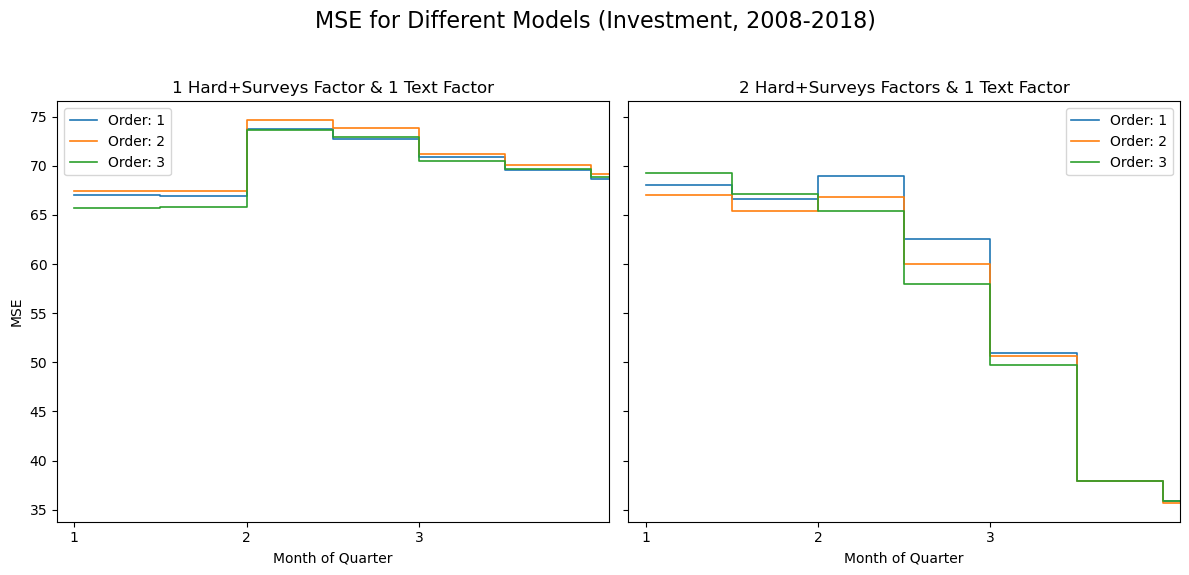

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


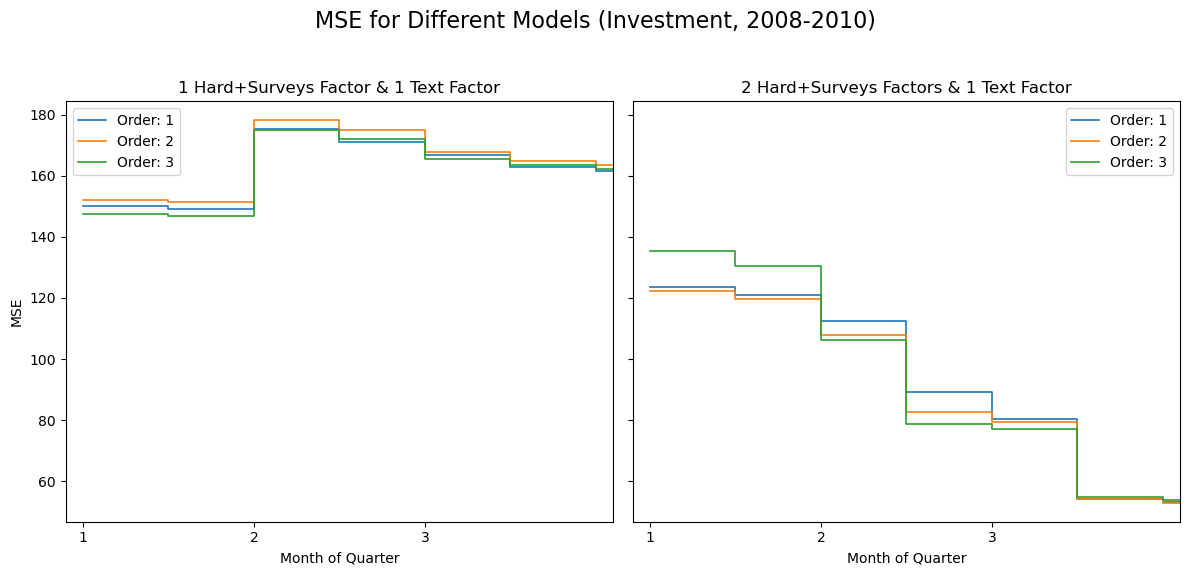

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


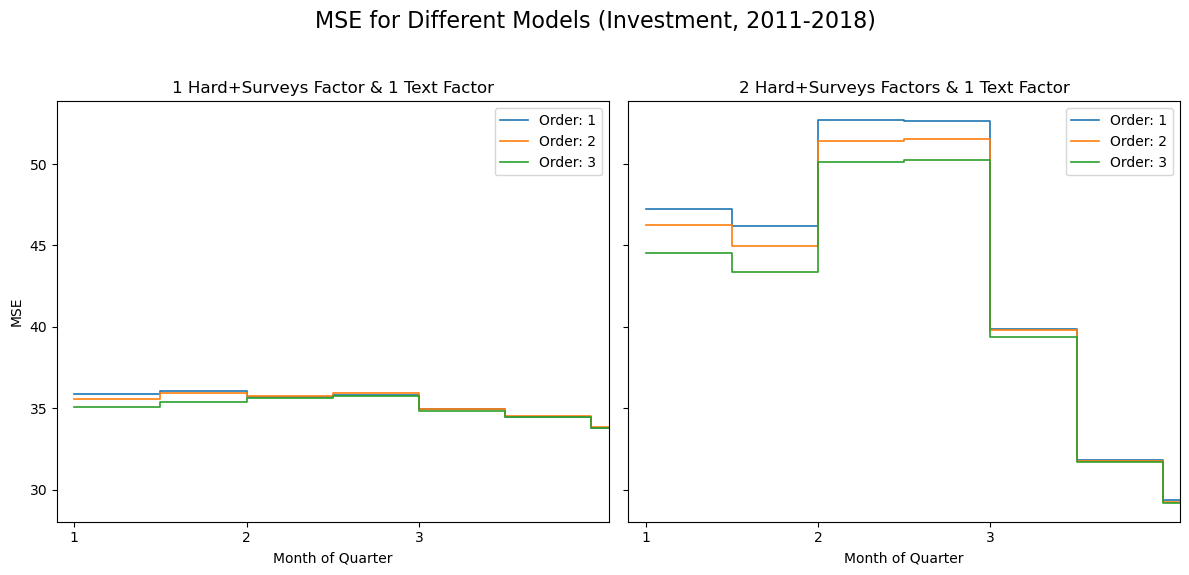

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


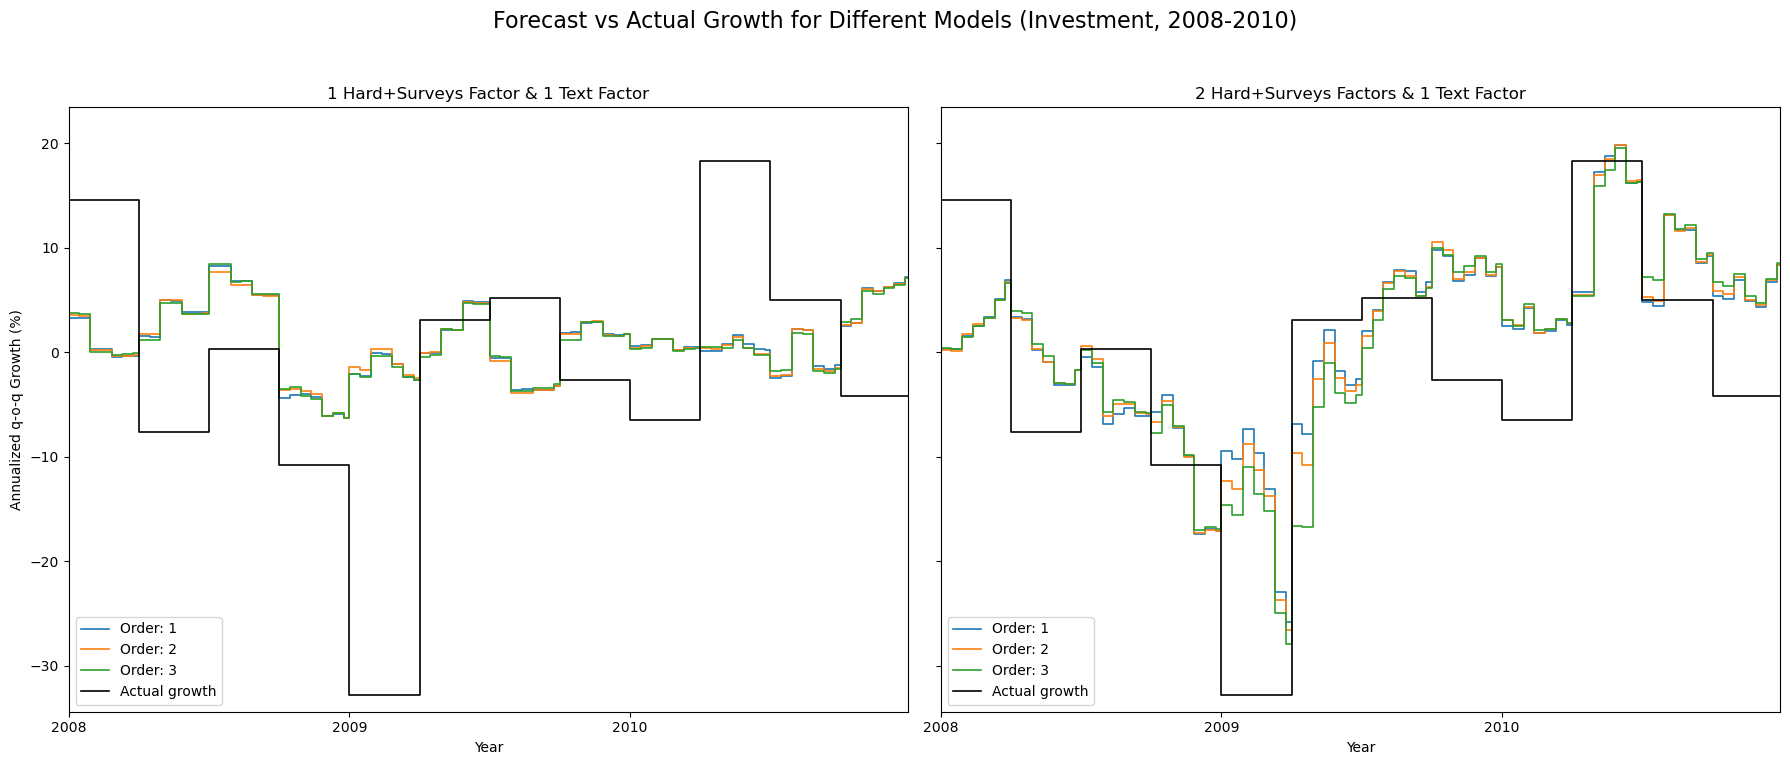

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


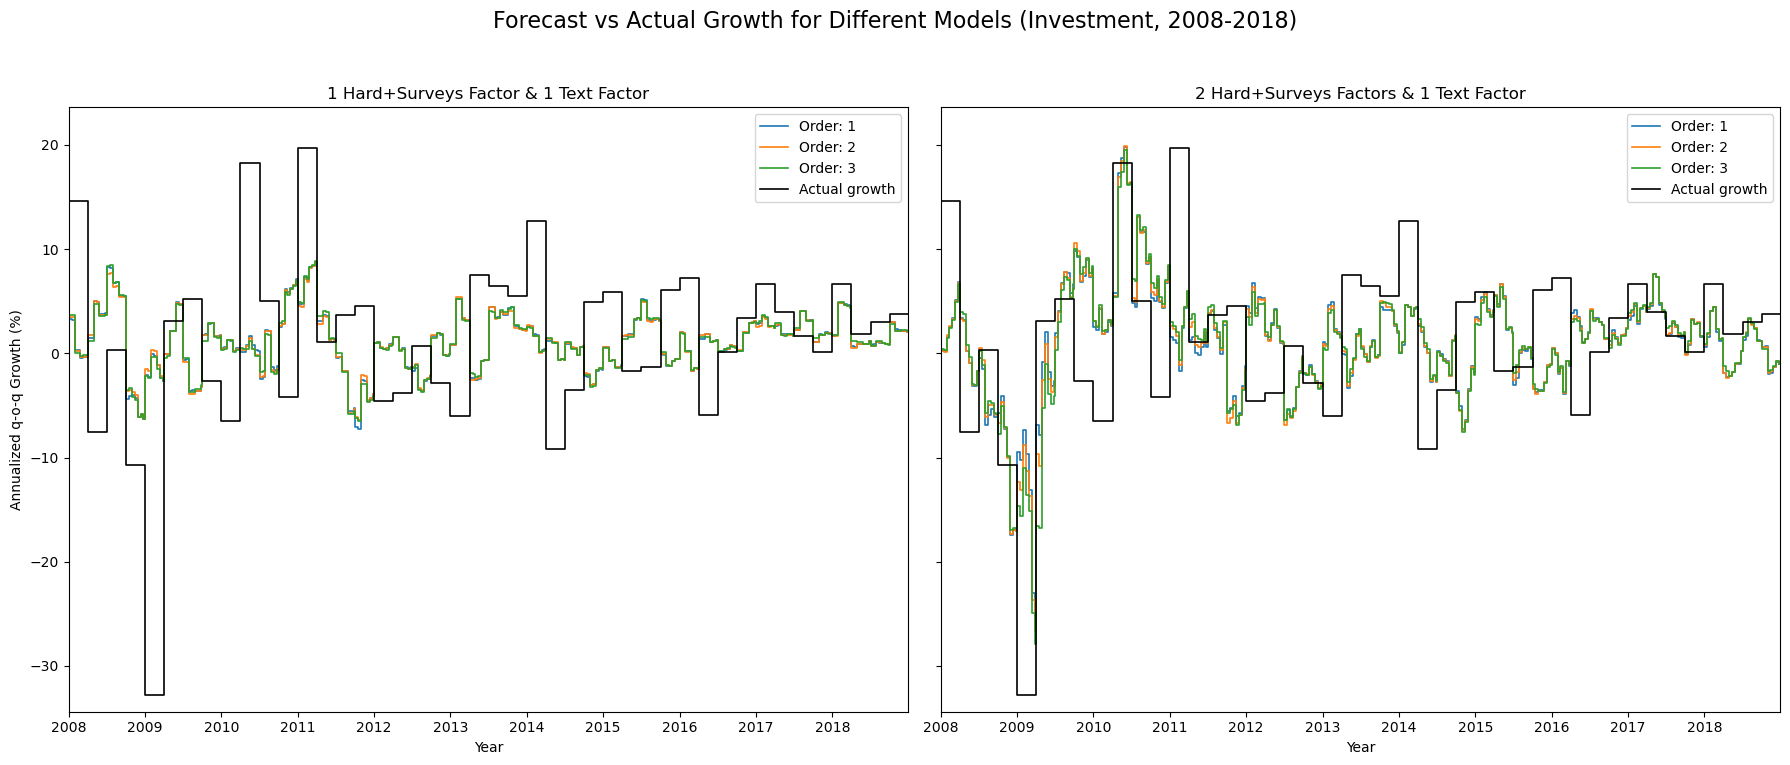

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


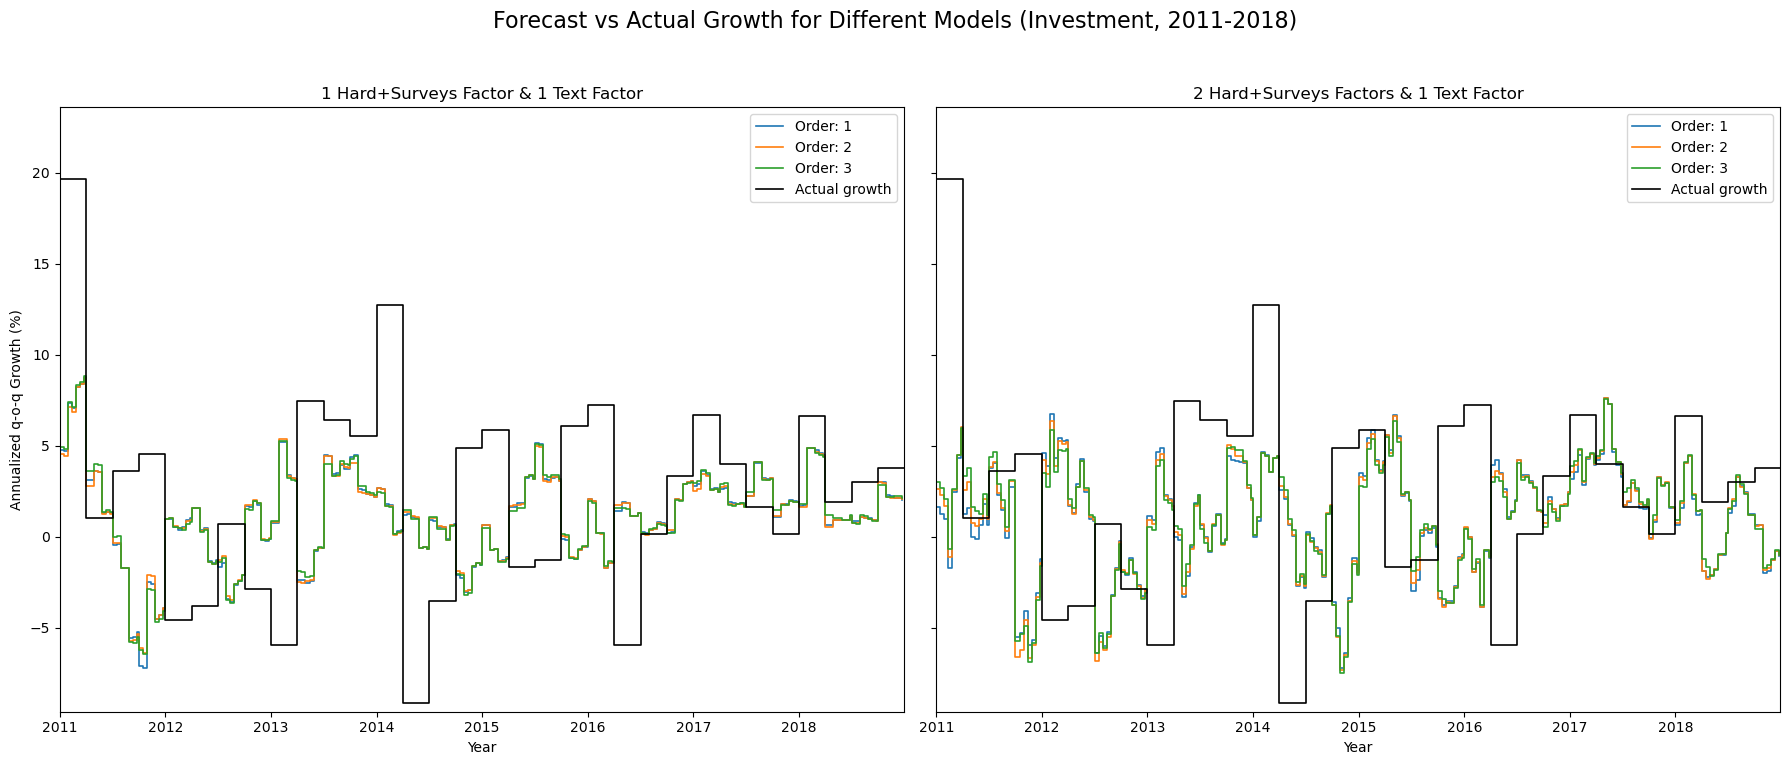

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()